# Import Package

In [1]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

from textblob import TextBlob
from tweepy import API
from tweepy import Cursor
from tweepy import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Credentials

In [2]:
CONSUMER_KEY = ''
CONSUMER_SECRET = ''
ACCESS_TOKEN = ''
ACCESS_TOKEN_SECRET = ''

# Class for Scraping

In [3]:
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
    
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
        
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends).items(num_friends):
            friend_list.append(friend)
            return friend_list
        
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

# Class for Authenticator

In [4]:
#twitter authenticator
class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        return auth

# Class for Reg[ex]

In [5]:
class TweetAnalyzer():
    def remove_emoji(self, tweet):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r" ", tweet)
    
    def cleanerText(self, tweet):
        tweet = re.sub(r'[0-9]', ' ',tweet) #remove number
        tweet = re.sub(r'@[A-Za-z0-9]+', ' ', tweet) #removed @mentions
        tweet = re.sub(r'#([a-zA-Z0-9_]+)', ' ', tweet) #removing # symbol
        tweet = re.sub(r'RT[\s]+', ' ', tweet) #removing 
        tweet = re.sub(r'(http|https):\/\/([\w\s\d\.]+)(\/?)(.*)',' ',tweet)#remove hyper link
        tweet = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet)
        tweet = tweet.lower()
        return tweet
    
    def cleaner(self, tweet):
        tweet = re.sub(r'[0-9]', ' ',tweet) #remove number
        tweet = re.sub(r'@[A-Za-z0-9]+', ' ', tweet) #removed @mentions
        tweet = re.sub(r'#([a-zA-Z0-9_]+)', ' ', tweet) #removing # symbol
        tweet = re.sub(r'RT[\s]+', ' ', tweet) #removing 
        tweet = re.sub(r'(http|https):\/\/([\w\s\d\.]+)(\/?)(.*)',' ',tweet)#remove hyper link
        tweet = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet)
        tweet = tweet.lower()
        return tweet.split()
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.cleanerText(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity ==0:
            return 0
        else:
            return -1
        
    #Store data into DataFrame
    #for analyze and categorizing content from tweets
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.full_text for tweet in tweets])
        df['tweets'] = np.array([tweet.full_text for tweet in tweets])
        df['tweet_id'] = np.array([tweet.id for tweet in tweets])
        df['username'] = np.array([tweet.user.screen_name for tweet in tweets])
        df['len'] = np.array([len(tweet.full_text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        df['location'] = np.array([tweet.user.location for tweet in tweets])
        df['is_Quotes']= np.array([tweet.is_quote_status for tweet in tweets])
        
        return df

# Init

In [6]:
if __name__ == '__main__':
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    api = twitter_client.get_twitter_client_api()

# Get Tweet from Jawa Barat

In [7]:
    #jawa barat
    searchTerms= "#sedih OR #marah OR #depresi OR menyedihkan OR kesepian OR sengsara OR sakit OR aku OR diriku sendiri OR selalu OR selengkapnya OR tidak pernah"
    tweets = [tweet for tweet in tweepy.Cursor(api.search, q=searchTerms +"-filter:retweets exclude:replies", lang = 'id', geocode="-6.814630,107.131828,200km", 
                                               tweet_mode="extended").items(3000)]
    
    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['deEmoji'] = np.array([tweet_analyzer.remove_emoji(tweet) for tweet in df['tweets']])
    df['deEmoji'] = np.array([tweet_analyzer.cleanerText(tweet) for tweet in df['tweets']])
    df['cleanTweet'] = np.array([tweet_analyzer.cleaner(tweet) for tweet in df['tweets']])
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    
    df = pd.DataFrame({'tweet_id': df['tweet_id'],'length of word': df['len'],'location': df['location'],'username': df['username'], 
                                           'tweet': df['tweets'], 'deEmoji': df['deEmoji'], 'cleanTweet': df['cleanTweet'], 'sentiment': df['sentiment'], 'date': df['date']})
    filename = 'jabar_excel.xlsx'
    filename2 = 'jabar_Csv.csv'
    df.to_excel(filename)
    df.to_csv(filename2)
    print('File berhasil dibuat')

File berhasil dibuat


# Get Tweet from Jawa Tengah

In [14]:
    #jawa tengah
    searchTerms= "#sedih OR #marah OR #depresi OR menyedihkan OR kesepian OR sengsara OR sakit OR aku OR diriku sendiri OR selalu OR selengkapnya OR tidak pernah"
    tweets = [tweet for tweet in tweepy.Cursor(api.search, q=searchTerms +"-filter:retweets exclude:replies", lang = 'id', geocode="-7.517260,110.593430,150km", 
                                               tweet_mode="extended").items(1500)]
    
    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['deEmoji'] = np.array([tweet_analyzer.remove_emoji(tweet) for tweet in df['tweets']])
    df['deEmoji'] = np.array([tweet_analyzer.cleanerText(tweet) for tweet in df['tweets']])
    df['cleanTweet'] = np.array([tweet_analyzer.cleaner(tweet) for tweet in df['tweets']])
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    
    df = pd.DataFrame({'tweet_id': df['tweet_id'],'length of word': df['len'],'location': df['location'],'username': df['username'], 
                                           'tweet': df['tweets'], 'deEmoji': df['deEmoji'], 'cleanTweet': df['cleanTweet'], 'sentiment': df['sentiment'], 'date': df['date']})
    filename = 'jateng_excel.xlsx'
    filename2 = 'jateng_Csv.csv'
    df.to_excel(filename)
    df.to_csv(filename2)
    print('File berhasil dibuat')

File berhasil dibuat


# Get Tweet from Jawa Timur

In [18]:
    #jawa timur
    searchTerms= "#sedih OR #marah OR #depresi OR menyedihkan OR kesepian OR sengsara OR sakit OR aku OR diriku sendiri OR selalu OR selengkapnya OR tidak pernah"
    tweets = [tweet for tweet in tweepy.Cursor(api.search, q=searchTerms +"-filter:retweets exclude:replies", lang = 'id', geocode="-7.781430,112.902344,150km", 
                                               tweet_mode="extended").items(1500)]
    
    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['deEmoji'] = np.array([tweet_analyzer.remove_emoji(tweet) for tweet in df['tweets']])
    df['deEmoji'] = np.array([tweet_analyzer.cleanerText(tweet) for tweet in df['tweets']])
    df['cleanTweet'] = np.array([tweet_analyzer.cleaner(tweet) for tweet in df['tweets']])
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    
    df = pd.DataFrame({'tweet_id': df['tweet_id'],'length of word': df['len'],'location': df['location'],'username': df['username'], 
                                           'tweet': df['tweets'], 'deEmoji': df['deEmoji'], 'cleanTweet': df['cleanTweet'], 'sentiment': df['sentiment'], 'date': df['date']})
    filename = 'jatim_excel.xlsx'
    filename2 = 'jatim_Csv.csv'
    df.to_excel(filename)
    df.to_csv(filename2)
    print('File berhasil dibuat')

File berhasil dibuat


# Get Tweet from Sumatra Utara

In [19]:
    #sumatra utara
    searchTerms= "#sedih OR #marah OR #depresi OR menyedihkan OR kesepian OR sengsara OR sakit OR aku OR diriku sendiri OR selalu OR selengkapnya OR tidak pernah"
    tweets = [tweet for tweet in tweepy.Cursor(api.search, q=searchTerms +"-filter:retweets exclude:replies", lang = 'id', geocode="2.8901607,99.1788304,140km", 
                                               tweet_mode="extended").items(1500)]

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['deEmoji'] = np.array([tweet_analyzer.remove_emoji(tweet) for tweet in df['tweets']])
    df['deEmoji'] = np.array([tweet_analyzer.cleanerText(tweet) for tweet in df['tweets']])
    df['cleanTweet'] = np.array([tweet_analyzer.cleaner(tweet) for tweet in df['tweets']])
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    
    df = pd.DataFrame({'tweet_id': df['tweet_id'],'length of word': df['len'],'location': df['location'],'username': df['username'], 
                                           'tweet': df['tweets'], 'deEmoji': df['deEmoji'], 'cleanTweet': df['cleanTweet'], 'sentiment': df['sentiment'], 'date': df['date']})
    filename = 'sumut_excel.xlsx'
    filename2 = 'sumut_Csv.csv'
    df.to_excel(filename)
    df.to_csv(filename2)
    print('File berhasil dibuat')

File berhasil dibuat


# Get Tweet from Sumatra Selatan

In [20]:
    #sumatra selatan
    searchTerms= "#sedih OR #marah OR #depresi OR menyedihkan OR kesepian OR sengsara OR sakit OR aku OR diriku sendiri OR selalu OR selengkapnya OR tidak pernah"
    tweets = [tweet for tweet in tweepy.Cursor(api.search, q=searchTerms +"-filter:retweets exclude:replies", lang = 'id', geocode="-3.13174,103.588986,200km", 
                                               tweet_mode="extended").items(1500)]

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['deEmoji'] = np.array([tweet_analyzer.remove_emoji(tweet) for tweet in df['tweets']])
    df['deEmoji'] = np.array([tweet_analyzer.cleanerText(tweet) for tweet in df['tweets']])
    df['cleanTweet'] = np.array([tweet_analyzer.cleaner(tweet) for tweet in df['tweets']])
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    
    df = pd.DataFrame({'tweet_id': df['tweet_id'],'length of word': df['len'],'location': df['location'],'username': df['username'], 
                                           'tweet': df['tweets'], 'deEmoji': df['deEmoji'], 'cleanTweet': df['cleanTweet'], 'sentiment': df['sentiment'], 'date': df['date']})
    filename = 'sumsel_excel.xlsx'
    filename2 = 'sumsel_Csv.csv'
    df.to_excel(filename)
    df.to_csv(filename2)
    print('File berhasil dibuat')

File berhasil dibuat


# Get Tweet from Bali

In [21]:
    #Bali
    searchTerms= "#sedih OR #marah OR #depresi OR menyedihkan OR kesepian OR sengsara OR sakit OR aku OR diriku sendiri OR selalu OR selengkapnya OR tidak pernah"
    tweets = [tweet for tweet in tweepy.Cursor(api.search, q=searchTerms +"-filter:retweets exclude:replies", lang = 'id', geocode="-8.340539,115.091949,73km", 
                                               tweet_mode="extended").items(1500)]

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['deEmoji'] = np.array([tweet_analyzer.remove_emoji(tweet) for tweet in df['tweets']])
    df['deEmoji'] = np.array([tweet_analyzer.cleanerText(tweet) for tweet in df['tweets']])
    df['cleanTweet'] = np.array([tweet_analyzer.cleaner(tweet) for tweet in df['tweets']])
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    
    df = pd.DataFrame({'tweet_id': df['tweet_id'],'length of word': df['len'],'location': df['location'],'username': df['username'], 
                                           'tweet': df['tweets'], 'deEmoji': df['deEmoji'], 'cleanTweet': df['cleanTweet'], 'sentiment': df['sentiment'], 'date': df['date']})
    filename = 'bali_excel.xlsx'
    filename2 = 'bali_Csv.csv'
    df.to_excel(filename)
    df.to_csv(filename2)
    print('File berhasil dibuat')

File berhasil dibuat


# PreProcessing - Import Package

In [1]:
import numpy as np 
import pandas as pd 
import re  
import nltk
import string
import matplotlib.pyplot as plt

nltk.download('stopwords')  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GL553VD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read Raw Data

In [2]:
tweets = pd.read_csv("Data10k_Csv.csv")

# Raw Data Ploting

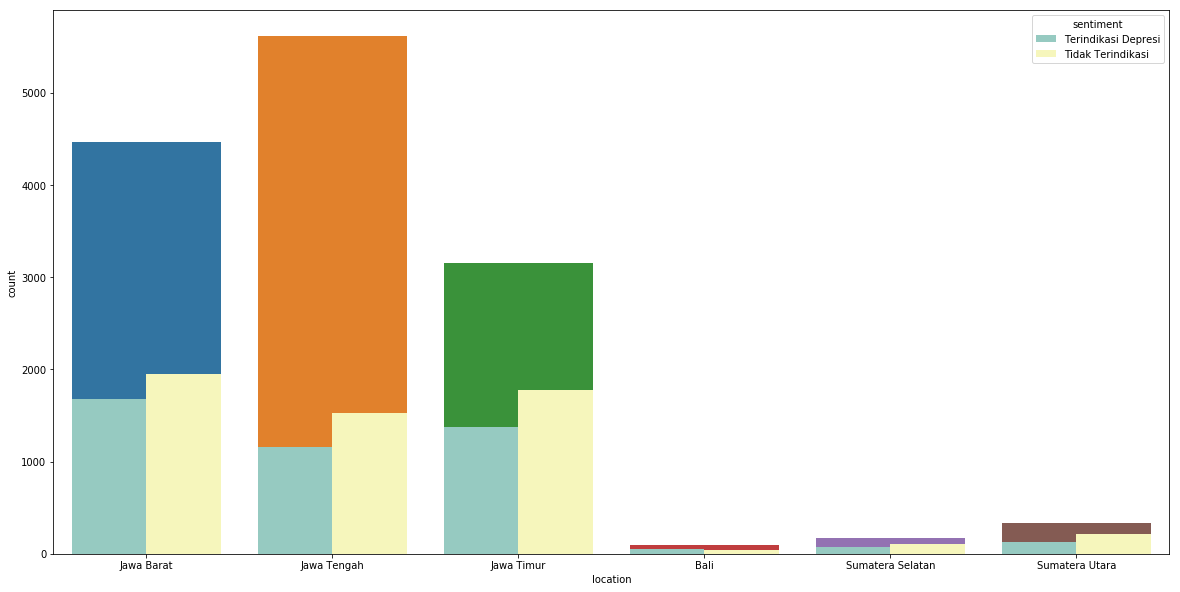

In [3]:
import seaborn as sns
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='sentiment', data=tweets)
sns.countplot(x='location', data=tweets)
sns.countplot(x='location', hue="sentiment", data=tweets, palette='Set3', ax=ax)

plt.show()

# Pick column

In [4]:
tweets.head()
tweets.shape
X = tweets.iloc[:, 7].values  
y = tweets.iloc[:, 8].values

In [5]:
print('List of raw Tweet : ', X[0:5])
print('\n')
print('List of raw Target : ', y[0:5])

List of raw Tweet :  ['mungkin kau selalu menduga diriku tidak pernah memahamimu bahkan kau selalu curiga ada yang lain dan kuduakan cintamu'
 'aku tidak kehilangan seorang teman pun aku hanya baru sadar kalau tidak pernah memilikinya'
 'manusia tidak akan pernah selesai dengan seluruh pertengkaran dendam kebencian bully dan caci maki kalau hanya saling menyombongkan kebenaran masing-masing menuhankan kebenaran masing-masing cobalah merendah oh barangkali aku yang salah mereka yang benar'
 'aku menyesal bahwa selama ini aku tidak pernah berani melangkah untuk memulai hal yang baru tapi aku sangat bersyukur hingga saat ini aku selalu dibersamai dengan orang yang selalu mendorong untuk berani maju melangkah'
 'jangan pernah merasa sendiri lihatlah aku yang tidak pernah pergi dan selalu berusaha untuk ada disaat kamu sedih meskipun terkadang aku menjauh saat kamu senang']


List of raw Target :  ['Terindikasi Depresi' 'Terindikasi Depresi' 'Tidak Terindikasi'
 'Tidak Terindikasi' 'Terindi

# Preprocessing - Case Folding

In [6]:
def case_folding(tweet):
    tweet = tweet.lower()
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    tweet = ' '.join(tweet.split())
    return tweet

In [7]:
X_da = [case_folding(tweet) for tweet in X]

In [8]:
print('List of Case Folded Tweet : ', X_da[0:5])

List of Case Folded Tweet :  ['mungkin kau selalu menduga diriku tidak pernah memahamimu bahkan kau selalu curiga ada yang lain dan kuduakan cintamu', 'aku tidak kehilangan seorang teman pun aku hanya baru sadar kalau tidak pernah memilikinya', 'manusia tidak akan pernah selesai dengan seluruh pertengkaran dendam kebencian bully dan caci maki kalau hanya saling menyombongkan kebenaran masingmasing menuhankan kebenaran masingmasing cobalah merendah oh barangkali aku yang salah mereka yang benar', 'aku menyesal bahwa selama ini aku tidak pernah berani melangkah untuk memulai hal yang baru tapi aku sangat bersyukur hingga saat ini aku selalu dibersamai dengan orang yang selalu mendorong untuk berani maju melangkah', 'jangan pernah merasa sendiri lihatlah aku yang tidak pernah pergi dan selalu berusaha untuk ada disaat kamu sedih meskipun terkadang aku menjauh saat kamu senang']


# PreProcessing - Tokenization

In [9]:
from nltk.tokenize import word_tokenize

In [10]:
X_da = [word_tokenize(tweet) for tweet in X]

In [11]:
print('List of Tokenize Tweet : ', X_da[0:5])

List of Tokenize Tweet :  [['mungkin', 'kau', 'selalu', 'menduga', 'diriku', 'tidak', 'pernah', 'memahamimu', 'bahkan', 'kau', 'selalu', 'curiga', 'ada', 'yang', 'lain', 'dan', 'kuduakan', 'cintamu'], ['aku', 'tidak', 'kehilangan', 'seorang', 'teman', 'pun', 'aku', 'hanya', 'baru', 'sadar', 'kalau', 'tidak', 'pernah', 'memilikinya'], ['manusia', 'tidak', 'akan', 'pernah', 'selesai', 'dengan', 'seluruh', 'pertengkaran', 'dendam', 'kebencian', 'bully', 'dan', 'caci', 'maki', 'kalau', 'hanya', 'saling', 'menyombongkan', 'kebenaran', 'masing-masing', 'menuhankan', 'kebenaran', 'masing-masing', 'cobalah', 'merendah', 'oh', 'barangkali', 'aku', 'yang', 'salah', 'mereka', 'yang', 'benar'], ['aku', 'menyesal', 'bahwa', 'selama', 'ini', 'aku', 'tidak', 'pernah', 'berani', 'melangkah', 'untuk', 'memulai', 'hal', 'yang', 'baru', 'tapi', 'aku', 'sangat', 'bersyukur', 'hingga', 'saat', 'ini', 'aku', 'selalu', 'dibersamai', 'dengan', 'orang', 'yang', 'selalu', 'mendorong', 'untuk', 'berani', 'maju',

# PreProcessing - Stopwords - NLTK

In [12]:
from nltk.corpus import stopwords

In [13]:
listStopword = set(stopwords.words('indonesian'))

In [14]:
def stopwords_removal(tweet):
    result = []
    for token in tweet:
        if token not in listStopword:
            result.append(token)
    return result

In [15]:
X_temp = []
for tweet in X_da:
    X_temp.append(stopwords_removal(tweet))

X_da = X_temp

In [16]:
print('List of Tweet After Stopwords : ', X_da[0:5])

List of Tweet After Stopwords :  [['kau', 'menduga', 'diriku', 'memahamimu', 'kau', 'curiga', 'kuduakan', 'cintamu'], ['kehilangan', 'teman', 'sadar', 'memilikinya'], ['manusia', 'selesai', 'pertengkaran', 'dendam', 'kebencian', 'bully', 'caci', 'maki', 'menyombongkan', 'kebenaran', 'menuhankan', 'kebenaran', 'cobalah', 'merendah', 'oh', 'barangkali', 'salah'], ['menyesal', 'berani', 'melangkah', 'bersyukur', 'dibersamai', 'orang', 'mendorong', 'berani', 'maju', 'melangkah'], ['lihatlah', 'pergi', 'berusaha', 'disaat', 'sedih', 'terkadang', 'menjauh', 'senang']]


# PreProcessing - Stemming

In [17]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [18]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [19]:
X_tempo = []
for tweet in X_da:
    X_tempo.append(stemmer.stem(' '.join(tweet)))
    
X_da = X_tempo

In [20]:
print('List of Tweet after stemming : ', X_tempo[0:5])

List of Tweet after stemming :  ['kau duga diri paham kau curiga dua cinta', 'hilang teman sadar milik', 'manusia selesai tengkar dendam benci bully caci maki sombong benar tuhan benar coba rendah oh barangkali salah', 'sesal berani lang syukur sama orang dorong berani maju lang', 'lihat pergi usaha saat sedih terkadang jauh senang']


# Save Preprocessed Data

In [21]:
file = open('clean.csv','w')
for line in X_da:
    file.write(line + "\n")
file.close()

# Load Preprocessed Data

In [22]:
X_dat = []

file = open('clean.csv','r')
for line in file:
    X_dat.append(line.rstrip())
file.close()

In [23]:
target = []
for sentimen in range(0, len(y)):
    senti = str(y[sentimen])
    if(senti == 'Tidak Terindikasi'):
        senti=0
    else:
        senti=1
    target.append(senti)

In [24]:
print(len(target), ' - ', type(target))
print(len(X_dat), ' - ', type(X_dat))

10082  -  <class 'list'>
10082  -  <class 'list'>


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dat, target, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_dat, target, test_size=0.33, random_state=42)

In [26]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

8065
2017
8065
2017


# Training and Evaluation

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB as MNB, ComplementNB as CNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# TF-IDF - Multinomial Naive Bayes - Word - CV 5

In [28]:
mnbc = MNB()
vectorizer = TfidfVectorizer()
model = Pipeline([('vectorizer', vectorizer), ('clf', mnbc)])

In [29]:
parameters = {
    'vectorizer__analyzer': ['word'],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [0, 5, 10],
    'vectorizer__ngram_range': [(1,1), (1,2), (2,2), (1,3), (2,3), (3,3)],
#     'vectorizer__ngram_range': [(3,3)],
    'vectorizer__max_features' : [10000, 15000, 20000, 25000, 30000, None]
}

result_mw = GridSearchCV(model, parameters, cv=5, scoring='f1_micro',n_jobs=-1)

In [30]:
result_mw.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vectorizer__analyzer': ['word'],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__max_features': [10000, 15000, 20000,
                                                      25000, 30000, None],
                         'vectorizer__min_df': [0, 5, 10],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2),
                                                     (1, 3), (2, 3), (3, 3)]},
             scoring='f1_micro')

In [31]:
print('Best Score : ', result_mw.best_score_)

Best Score :  0.903657780533168


In [32]:
print('Best Param : ', result_mw.best_params_)

Best Param :  {'vectorizer__analyzer': 'word', 'vectorizer__max_df': 0.9, 'vectorizer__max_features': None, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 3)}


In [33]:
pred = result_mw.predict(X_test)
pred_proba = result_mw.predict_proba(X_test)

print(pred)
print('\n')
print(pred_proba)

[0 1 1 ... 1 0 0]


[[9.99748488e-01 2.51511949e-04]
 [1.72620878e-01 8.27379122e-01]
 [2.53408101e-01 7.46591899e-01]
 ...
 [2.76456756e-01 7.23543244e-01]
 [7.05856756e-01 2.94143244e-01]
 [8.09292057e-01 1.90707943e-01]]


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('accuracy: ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

accuracy:  0.9385225582548339
[[1079   36]
 [  88  814]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1115
           1       0.96      0.90      0.93       902

    accuracy                           0.94      2017
   macro avg       0.94      0.94      0.94      2017
weighted avg       0.94      0.94      0.94      2017



# TF-IDF - Multinomial Naive Bayes - Char

In [38]:
mnbc = MNB()
vectorizer = TfidfVectorizer()
model = Pipeline([('vectorizer', vectorizer), ('clf', mnbc)])

In [39]:
parameters = {
    'vectorizer__analyzer': ['char'],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [0, 5, 10],
    'vectorizer__ngram_range': [(2,3), (3,3), (3,4), (3,5), (4,5), (5,5)],
#     'vectorizer__ngram_range': [(5,5)],
    'vectorizer__max_features' : [10000, 15000, 20000, 25000, 30000, None]
}

result_mc = GridSearchCV(model, parameters, cv=5, scoring='f1_micro',n_jobs=-1)

In [40]:
result_mc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vectorizer__analyzer': ['char'],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__max_features': [10000, 15000, 20000,
                                                      25000, 30000, None],
                         'vectorizer__min_df': [0, 5, 10],
                         'vectorizer__ngram_range': [(5, 5)]},
             scoring='f1_micro')

In [41]:
print('Best Score : ', result_mc.best_score_)

Best Score :  0.8412895226286423


In [42]:
print('Best Param : ', result_mc.best_params_)

Best Param :  {'vectorizer__analyzer': 'char', 'vectorizer__max_df': 0.9, 'vectorizer__max_features': None, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (5, 5)}


In [43]:
pred = result_mc.predict(X_test)
pred_proba = result_mc.predict_proba(X_test)

print(pred)
print('\n')
print(pred_proba)

[0 1 1 ... 1 0 0]


[[9.99656979e-01 3.43020684e-04]
 [3.43910848e-01 6.56089152e-01]
 [3.12652911e-01 6.87347089e-01]
 ...
 [1.79034805e-01 8.20965195e-01]
 [7.15466355e-01 2.84533645e-01]
 [7.80760358e-01 2.19239642e-01]]


In [44]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('accuracy: ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

accuracy:  0.8626673277144273
[[1020   95]
 [ 182  720]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1115
           1       0.88      0.80      0.84       902

    accuracy                           0.86      2017
   macro avg       0.87      0.86      0.86      2017
weighted avg       0.86      0.86      0.86      2017



# TF-IDF - Complement NB - Word

In [28]:
cnbc = CNB()
vectorizer = TfidfVectorizer()
model = Pipeline([('vectorizer', vectorizer), ('clf', cnbc)])

In [29]:
parameters = {
    'vectorizer__analyzer': ['word'],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [0, 5, 10],
    'vectorizer__ngram_range': [(1,1), (1,2), (2,2), (1,3), (2,3), (3,3)],
#     'vectorizer__ngram_range': [(3,3)],
    'vectorizer__max_features' : [10000, 15000, 20000, 25000, 30000, None]
}

result_cnw = GridSearchCV(model, parameters, cv=5, scoring='f1_micro',n_jobs=-1)

In [30]:
result_cnw.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             n_jobs=-1,
             param_grid={'vectorizer__analyzer': ['word'],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__max_features': [10000, 15000, 20000,
                                                      25000, 30000, None],
                         'vectorizer__min_df': [0, 5, 10],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2),
                                                     (1, 3), (2, 3), (3, 3)]},
             scoring='f1_micro')

In [31]:
print('Best Score : ', result_cnw.best_score_)

Best Score :  0.9088654680719156


In [32]:
print('Best Param : ', result_cnw.best_params_)

Best Param :  {'vectorizer__analyzer': 'word', 'vectorizer__max_df': 0.9, 'vectorizer__max_features': None, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 3)}


In [33]:
pred = result_cnw.predict(X_test)
pred_proba = result_cnw.predict_proba(X_test)

print(pred)
print('\n')
print(pred_proba)

[0 1 1 ... 1 0 0]


[[9.99682225e-01 3.17774837e-04]
 [1.41719144e-01 8.58280856e-01]
 [2.11745431e-01 7.88254569e-01]
 ...
 [2.32183144e-01 7.67816856e-01]
 [6.55075873e-01 3.44924127e-01]
 [7.70563868e-01 2.29436132e-01]]


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('accuracy: ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

accuracy:  0.9335647000495786
[[1051   64]
 [  70  832]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1115
           1       0.93      0.92      0.93       902

    accuracy                           0.93      2017
   macro avg       0.93      0.93      0.93      2017
weighted avg       0.93      0.93      0.93      2017



# TF-IDF - Complement NB - Char

In [52]:
cnbc = CNB()
vectorizer = TfidfVectorizer()
model = Pipeline([('vectorizer', vectorizer), ('clf', cnbc)])

In [53]:
parameters = {
    'vectorizer__analyzer': ['char'],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [0, 5, 10],
    'vectorizer__ngram_range': [(2,3), (3,3), (3,4), (3,5), (4,5), (5,5)],
#         'vectorizer__ngram_range': [(5,5)],
    'vectorizer__max_features' : [10000, 15000, 20000, 25000, 30000, None]
}

result_cnc = GridSearchCV(model, parameters, cv=5, scoring='f1_micro',n_jobs=-1)

In [54]:
result_cnc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             n_jobs=-1,
             param_grid={'vectorizer__analyzer': ['char'],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__max_features': [10000, 15000, 20000,
                                                      25000, 30000, None],
                         'vectorizer__min_df': [0, 5, 10],
                         'vectorizer__ngram_range': [(2, 3), (3, 3), (3, 4),
                                                     (3, 5), (4, 5), (5, 5)]},
             scoring='f1_micro')

In [55]:
print('Best Score : ', result_cnc.best_score_)

Best Score :  0.8469931804091756


In [56]:
print('Best Param : ', result_cnc.best_params_)

Best Param :  {'vectorizer__analyzer': 'char', 'vectorizer__max_df': 0.9, 'vectorizer__max_features': None, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (5, 5)}


In [57]:
pred = result_cnc.predict(X_test)
pred_proba = result_cnc.predict_proba(X_test)

print(pred)
print('\n')
print(pred_proba)

[0 1 1 ... 1 0 0]


[[9.99566618e-01 4.33381849e-04]
 [2.93212371e-01 7.06787629e-01]
 [2.64703287e-01 7.35296713e-01]
 ...
 [1.47189142e-01 8.52810858e-01]
 [6.65558423e-01 3.34441577e-01]
 [7.38113039e-01 2.61886961e-01]]


In [58]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('accuracy: ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

accuracy:  0.8621715418939019
[[975 140]
 [138 764]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1115
           1       0.85      0.85      0.85       902

    accuracy                           0.86      2017
   macro avg       0.86      0.86      0.86      2017
weighted avg       0.86      0.86      0.86      2017



# TF-IDF - Multinomial Naive Bayes - Word - CV 10

In [59]:
mnbc_cv = MNB()
vectorizer = TfidfVectorizer()
model = Pipeline([('vectorizer', vectorizer), ('clf', mnbc_cv)])

In [60]:
parameters = {
    'vectorizer__analyzer': ['word'],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [0, 5, 10],
    'vectorizer__ngram_range': [(1,1), (1,2), (2,2), (1,3), (2,3), (3,3)],
    'vectorizer__max_features' : [10000, 15000, 20000, 25000, 30000, None]
}

result_cvmw = GridSearchCV(model, parameters, cv=10, scoring='f1_micro',n_jobs=-1)

In [61]:
result_cvmw.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vectorizer__analyzer': ['word'],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__max_features': [10000, 15000, 20000,
                                                      25000, 30000, None],
                         'vectorizer__min_df': [0, 5, 10],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2),
                                                     (1, 3), (2, 3), (3, 3)]},
             scoring='f1_micro')

In [62]:
print('Best Score : ', result_cvmw.best_score_)

Best Score :  0.9130797211742168


In [63]:
print('Best Param : ', result_cvmw.best_params_)

Best Param :  {'vectorizer__analyzer': 'word', 'vectorizer__max_df': 0.9, 'vectorizer__max_features': None, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 3)}


In [64]:
pred = result_cvmw.predict(X_test)

print('accuracy: ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

accuracy:  0.9385225582548339
[[1079   36]
 [  88  814]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1115
           1       0.96      0.90      0.93       902

    accuracy                           0.94      2017
   macro avg       0.94      0.94      0.94      2017
weighted avg       0.94      0.94      0.94      2017



In [65]:
print(result_cvmw.cv_results_)

{'mean_fit_time': array([0.17956362, 0.37369068, 0.27780712, 0.64413264, 0.54722795,
       0.25972943, 0.12303402, 0.35378349, 0.25940597, 0.65125875,
       0.54130673, 0.27424982, 0.11565559, 0.32156544, 0.23771651,
       0.60653005, 0.51381032, 0.2649467 , 0.10888317, 0.43746281,
       0.33431814, 0.67568164, 0.64433355, 0.30465419, 0.10953579,
       0.33935406, 0.25090964, 0.82212396, 0.83874543, 0.38038735,
       0.12310071, 0.4110729 , 0.42007973, 0.70630803, 0.62140725,
       0.30715885, 0.12509415, 0.36954265, 0.29046192, 0.73051302,
       0.57310543, 0.31258061, 0.12259519, 0.34783833, 0.27090402,
       0.68054619, 0.57086589, 0.38644226, 0.12430534, 0.36106122,
       0.26802344, 0.68494389, 0.60317235, 0.28505881, 0.12683938,
       0.39015493, 0.29012442, 0.69842939, 0.65476005, 0.41509125,
       0.14106975, 0.38184683, 0.27665803, 0.66907232, 0.62446787,
       0.30517972, 0.1229866 , 0.36834092, 0.26468365, 0.6666342 ,
       0.55780282, 0.29046726, 0.11865194, 0

# TF-IDF - Multinomial Naive Bayes - Char

In [66]:
mnbc_cv = MNB()
vectorizer = TfidfVectorizer()
model = Pipeline([('vectorizer', vectorizer), ('clf', mnbc_cv)])

In [67]:
parameters = {
    'vectorizer__analyzer': ['char'],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [0, 5, 10],
    'vectorizer__ngram_range': [(2,3), (3,3), (3,4), (3,5), (4,5), (5,5)],
    'vectorizer__max_features' : [10000, 15000, 20000, 25000, 30000, None]
}

result_cvmc = GridSearchCV(model, parameters, cv=10, scoring='f1_micro',n_jobs=-1)

In [68]:
result_cvmc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vectorizer__analyzer': ['char'],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__max_features': [10000, 15000, 20000,
                                                      25000, 30000, None],
                         'vectorizer__min_df': [0, 5, 10],
                         'vectorizer__ngram_range': [(2, 3), (3, 3), (3, 4),
                                                     (3, 5), (4, 5), (5, 5)]},
             scoring='f1_micro')

In [69]:
print('Best Score : ', result_cvmc.best_score_)

Best Score :  0.8536897986292399


In [70]:
print('Best Param : ', result_cvmc.best_params_)

Best Param :  {'vectorizer__analyzer': 'char', 'vectorizer__max_df': 0.9, 'vectorizer__max_features': None, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (5, 5)}


In [71]:
pred = result_cvmc.predict(X_test)

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('accuracy: ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

accuracy:  0.8626673277144273
[[1020   95]
 [ 182  720]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1115
           1       0.88      0.80      0.84       902

    accuracy                           0.86      2017
   macro avg       0.87      0.86      0.86      2017
weighted avg       0.86      0.86      0.86      2017



# TF-IDF - Complement NB - Word

In [73]:
cnbc_cv = CNB()
vectorizer = TfidfVectorizer()
model = Pipeline([('vectorizer', vectorizer), ('clf', cnbc_cv)])

In [74]:
parameters = {
    'vectorizer__analyzer': ['word'],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [0, 5, 10],
    'vectorizer__ngram_range': [(1,1), (1,2), (2,2), (1,3), (2,3), (3,3)],
    'vectorizer__max_features' : [10000, 15000, 20000, 25000, 30000, None]
}

result_cvcw = GridSearchCV(model, parameters, cv=10, scoring='f1_micro',n_jobs=-1)

In [75]:
result_cvcw.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             n_jobs=-1,
             param_grid={'vectorizer__analyzer': ['word'],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__max_features': [10000, 15000, 20000,
                                                      25000, 30000, None],
                         'vectorizer__min_df': [0, 5, 10],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2),
                                                     (1, 3), (2, 3), (3, 3)]},
             scoring='f1_micro')

In [76]:
print('Best Score : ', result_cvcw.best_score_)

Best Score :  0.9198992377490999


In [77]:
print('Best Param : ', result_cvcw.best_params_)

Best Param :  {'vectorizer__analyzer': 'word', 'vectorizer__max_df': 0.9, 'vectorizer__max_features': None, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 3)}


In [78]:
pred = result_cvcw.predict(X_test)
pred_proba = result_cvcw.predict_proba(X_test)

print(pred)
print('\n')
print(pred_proba)

[0 1 1 ... 1 0 0]


[[9.99682225e-01 3.17774837e-04]
 [1.41719144e-01 8.58280856e-01]
 [2.11745431e-01 7.88254569e-01]
 ...
 [2.32183144e-01 7.67816856e-01]
 [6.55075873e-01 3.44924127e-01]
 [7.70563868e-01 2.29436132e-01]]


In [79]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('accuracy: ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

accuracy:  0.9335647000495786
[[1051   64]
 [  70  832]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1115
           1       0.93      0.92      0.93       902

    accuracy                           0.93      2017
   macro avg       0.93      0.93      0.93      2017
weighted avg       0.93      0.93      0.93      2017



# TF-IDF - Complement NB - Char

In [80]:
cnbc_cv = CNB()
vectorizer = TfidfVectorizer()
model = Pipeline([('vectorizer', vectorizer), ('clf', cnbc_cv)])

In [81]:
parameters = {
    'vectorizer__analyzer': ['char'],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [0, 5, 10],
    'vectorizer__ngram_range': [(2,3), (3,3), (3,4), (3,5), (4,5), (5,5)],
    'vectorizer__max_features' : [10000, 15000, 20000, 25000, 30000, None]
}

result_cvcc = GridSearchCV(model, parameters, cv=10, scoring='f1_micro',n_jobs=-1)

In [82]:
result_cvcc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             n_jobs=-1,
             param_grid={'vectorizer__analyzer': ['char'],
                         'vectorizer__max_df': [0.9, 0.95, 1.0],
                         'vectorizer__max_features': [10000, 15000, 20000,
                                                      25000, 30000, None],
                         'vectorizer__min_df': [0, 5, 10],
                         'vectorizer__ngram_range': [(2, 3), (3, 3), (3, 4),
                                                     (3, 5), (4, 5), (5, 5)]},
             scoring='f1_micro')

In [83]:
print('Best Score : ', result_cvcc.best_score_)

Best Score :  0.8543112222150476


In [84]:
print('Best Param : ', result_cvcc.best_params_)

Best Param :  {'vectorizer__analyzer': 'char', 'vectorizer__max_df': 0.9, 'vectorizer__max_features': None, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (5, 5)}


In [85]:
pred = result_cnc.predict(X_test)
pred_proba = result_cnc.predict_proba(X_test)

print(pred)
print('\n')
print(pred_proba)

[0 1 1 ... 1 0 0]


[[9.99566618e-01 4.33381849e-04]
 [2.93212371e-01 7.06787629e-01]
 [2.64703287e-01 7.35296713e-01]
 ...
 [1.47189142e-01 8.52810858e-01]
 [6.65558423e-01 3.34441577e-01]
 [7.38113039e-01 2.61886961e-01]]


In [86]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('accuracy: ', accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

accuracy:  0.8621715418939019
[[975 140]
 [138 764]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1115
           1       0.85      0.85      0.85       902

    accuracy                           0.86      2017
   macro avg       0.86      0.86      0.86      2017
weighted avg       0.86      0.86      0.86      2017

